In [13]:
import os
import cv2
import torch
import numpy as np
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt

from video import Video
from tracker import MultiObjectTracker
from plot_utils import plot_bounding_boxes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
"""
https://stackoverflow.com/questions/53014306/error-15-initializing-libiomp5-dylib-but-found-libiomp5-dylib-already-initial/54533223#54533223
"""

print(f'torch {torch.__version__}')
print(torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU')

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

torch 1.9.0
CPU


In [334]:
def get_SIFT_features(frames):
    sift = cv2.SIFT_create()
    key_points, descriptors = [], []
    for frame in frames:
        curr_key_points, curr_descriptors = sift.detectAndCompute(frame, None)
        key_points.append(curr_key_points)
        descriptors.append(curr_descriptors)
    return key_points, descriptors


def blur(img, method, kernel_size=5):
    if method == 'Low Pass':
        kernel = np.ones((kernel_size, kernel_size), np.float32)/25
        return cv2.filter2D(img, -1, kernel)

    elif method == 'Bilateral Filter':
        return cv2.bilateralFilter(img, kernel_size, 75, 75)

    elif method == 'Gaussian Blur':
        return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


class FeatureMatcher:
    def __init__(self, matcher_trees=5, matcher_checks=50):
        self.sift = cv2.SIFT_create()

        FLAN_INDEX_KDTREE = 0
        index_params = dict(algorithm=FLAN_INDEX_KDTREE, trees=matcher_trees)
        search_params = dict(checks=matcher_checks)
        self.matcher = cv2.FlannBasedMatcher(index_params, search_params)

    def match(self, img1, img2, max_distance_diff=0.25, display=False):
        key_points1, descriptors1 = self.sift.detectAndCompute(img1, None)
        key_points2, descriptors2 = self.sift.detectAndCompute(img2, None)
        matches = self.matcher.knnMatch(descriptors1, descriptors2, k=2)

        good_key_points1 = []
        good_key_points2 = []
        good_matches = []
        for m1, m2 in matches:
            if m1.distance < m2.distance * max_distance_diff:
                good_matches.append([m1])
                good_key_points1.append(key_points1[m1.queryIdx].pt)
                good_key_points2.append(key_points2[m1.trainIdx].pt)

        matches_plot = cv2.drawMatchesKnn(img1[::, ::, ::-1], key_points1,
                                          img2[::, ::, ::-1], key_points2,
                                          good_matches, None, flags=2)
        
        if display:
            plt.figure(dpi=200)
            plt.imshow(matches_plot)
            plt.axis('off')
            plt.tight_layout()
            plt.show()

        return good_key_points1, good_key_points2, matches_plot

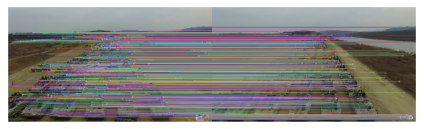

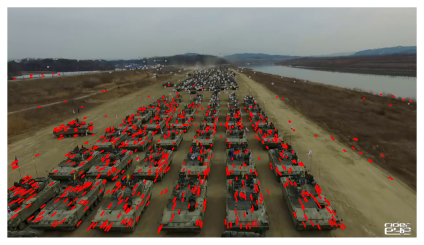

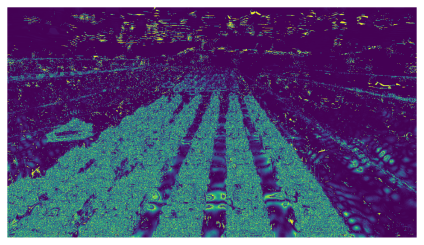

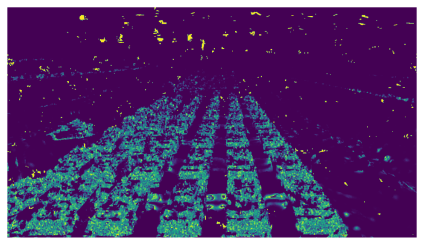

In [611]:
input_video_path = 'test_videos/My Movie2.mp4'
video = Video(input_video_path)
frames = video.get_frames_tensor()
# key_points, descriptors = get_SIFT_features(frames)

t0 = 20

img1 = frames[t0]
img2 = frames[t0 + 1]

matcher = FeatureMatcher()
list_kp1, list_kp2, matches_plot = matcher.match(img1, img2, 0.25, display=True)


plt.figure(dpi=200)
plt.imshow(img1[::, ::, ::-1])
for kp1, kp2 in zip(list_kp1, list_kp2):
    diff_x = kp1[0] - kp2[0]
    diff_y = kp1[1] - kp2[1]
    diff_abs = np.sqrt(diff_x**2 + diff_y**2)
    
    plot_color = 'r' if diff_abs > 1 else 'grey'
    plt.plot([kp1[0], kp2[0]], [kp1[1], kp2[1]], color=plot_color)
          
plt.axis('off') 
plt.tight_layout()
plt.show()

# Frame difference

def preprocess_frame(frame, color_space='BGR', blur_method=None, kernel_size=None):
    if blur_method:
        frame = blur(frame, blur_method, kernel_size)
    if color_space == 'LAB':
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2LAB)
    if color_space == 'HSV':
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        
    return frame


frame_LAB = lambda t: preprocess_frame(frames[t], color_space='LAB', blur_method='Bilateral Filter', kernel_size=25)
frame_HSV = lambda t: preprocess_frame(frames[t], color_space='HSV', blur_method='Bilateral Filter', kernel_size=25)

frames_diff_LAB = lambda t1, t2: frame_LAB(t2) - frame_LAB(t1)
frames_diff_HSV = lambda t1, t2: frame_HSV(t2) - frame_HSV(t1)

dt = 2

diff_t1_LAB = frames_diff_LAB(t0, t0+dt)
diff_t1_HSV = frames_diff_HSV(t0, t0+dt)
diff_t2_LAB = frames_diff_LAB(t0+dt, t0+dt*2)
diff_t2_HSV = frames_diff_HSV(t0+dt, t0+dt*2)

diff_of_diff_LAB_L = (diff_t2_LAB - diff_t1_LAB)[::,::,0]
diff_of_diff_HSV_V = (diff_t2_HSV - diff_t1_HSV)[::,::,2]

diff_mask = diff_of_diff_LAB_L * diff_of_diff_HSV_V 

plt.figure(dpi=200)
plt.imshow(diff_mask)
plt.axis('off')
plt.tight_layout()
plt.show()

inverse_diff = frames_diff_LAB(t0+dt, t0)[::,::,0]
inverse_diff = inverse_diff / np.max(inverse_diff)
diff_mask = diff_mask * (inverse_diff > 0.1)

diff_mask = cv2.morphologyEx(diff_mask, cv2.MORPH_CLOSE, np.ones((1,3),np.uint8))
diff_mask = cv2.morphologyEx(diff_mask, cv2.MORPH_CLOSE, np.ones((3,1),np.uint8))
diff_mask = cv2.morphologyEx(diff_mask, cv2.MORPH_OPEN , np.ones((2,2),np.uint8))

diff_mask = diff_mask / np.max(diff_mask)
diff_mask[np.where(diff_mask<=0.01)] = 0

plt.figure(dpi=200)
plt.imshow(diff_mask**2)
plt.axis('off')
plt.tight_layout()
plt.show()

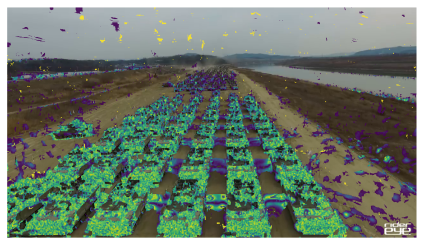

array([[        nan,         nan,         nan, ...,         nan,         nan,         nan],
       [        nan,         nan,         nan, ...,         nan,         nan,         nan],
       [        nan,         nan,         nan, ...,         nan,         nan,         nan],
       ...,
       [    0.61961,     0.61961,     0.61961, ...,    0.047059,    0.047059,    0.047059],
       [        nan,         nan,         nan, ...,    0.047059,    0.047059,    0.047059],
       [        nan,         nan,         nan, ...,    0.047059,    0.047059,    0.047059]])

In [612]:
diff_mask[np.where(diff_mask<=0.01)] = np.nan

plt.figure(dpi=200)
plt.imshow(img1[::, ::, ::-1])
plt.imshow(diff_mask, alpha=0.95)
          
plt.axis('off') 
plt.tight_layout()
plt.show()

diff_mask